['Pclass_1', 'Pclass_2', 'Sex_female', 'Embarked_C', 'Embarked_Q']


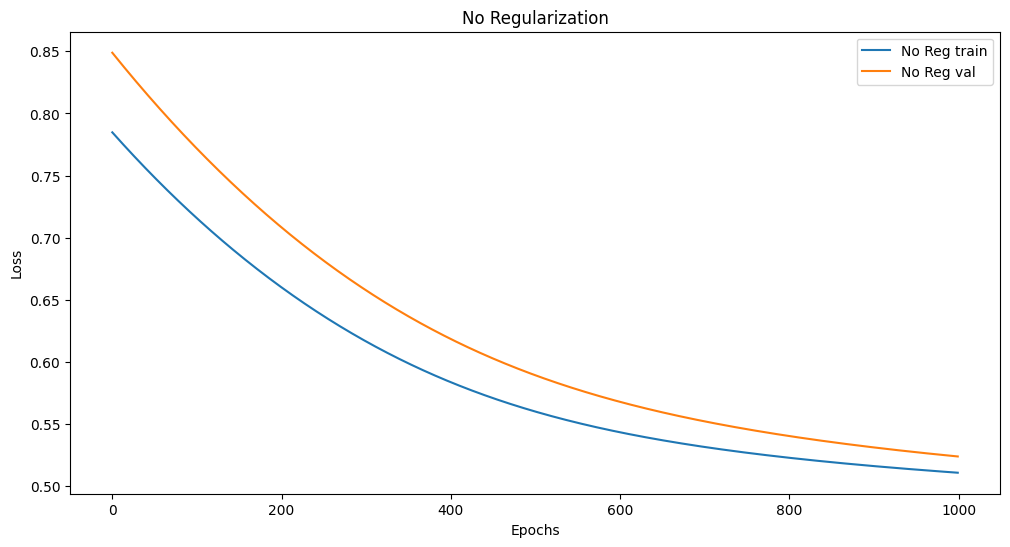

No Reg Validation BCE: 0.5237510738876026


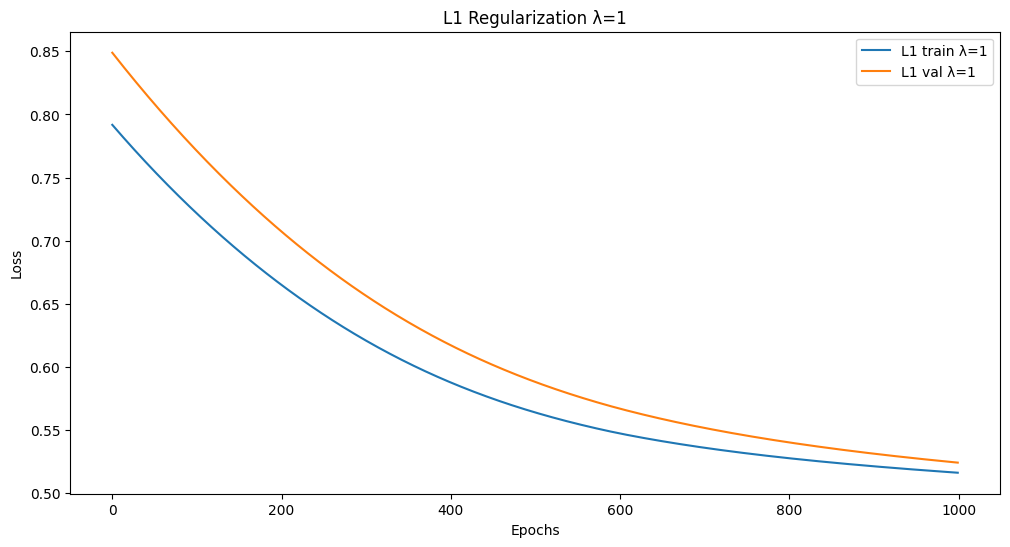

L1 Reg Validation BCE with λ=1: 0.5241111884128699


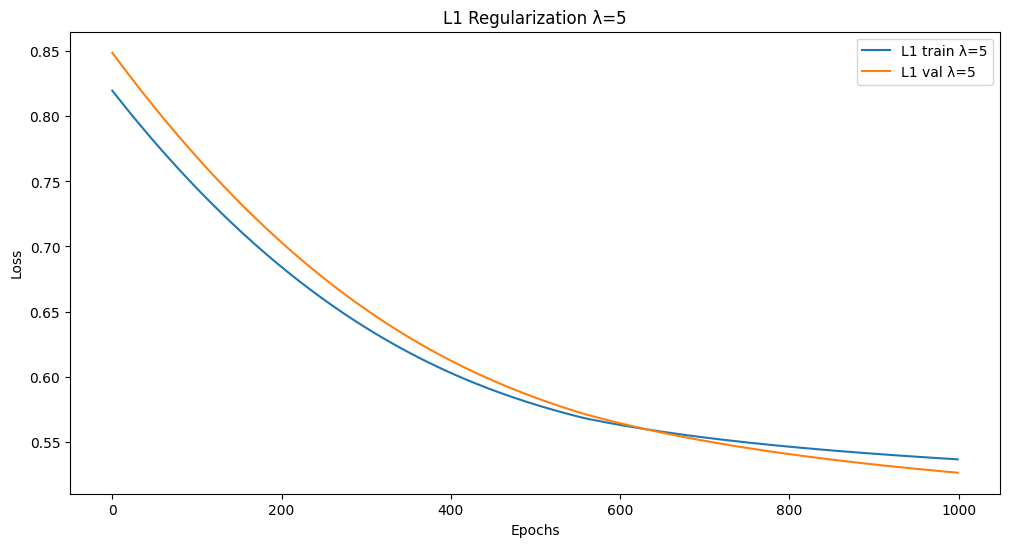

L1 Reg Validation BCE with λ=5: 0.5261265796565452


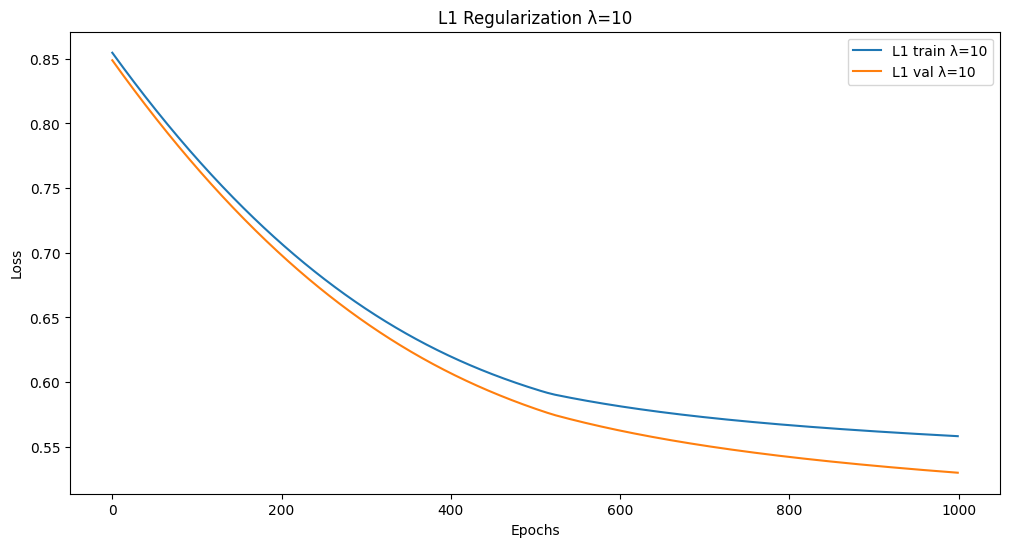

L1 Reg Validation BCE with λ=10: 0.5298759840174241


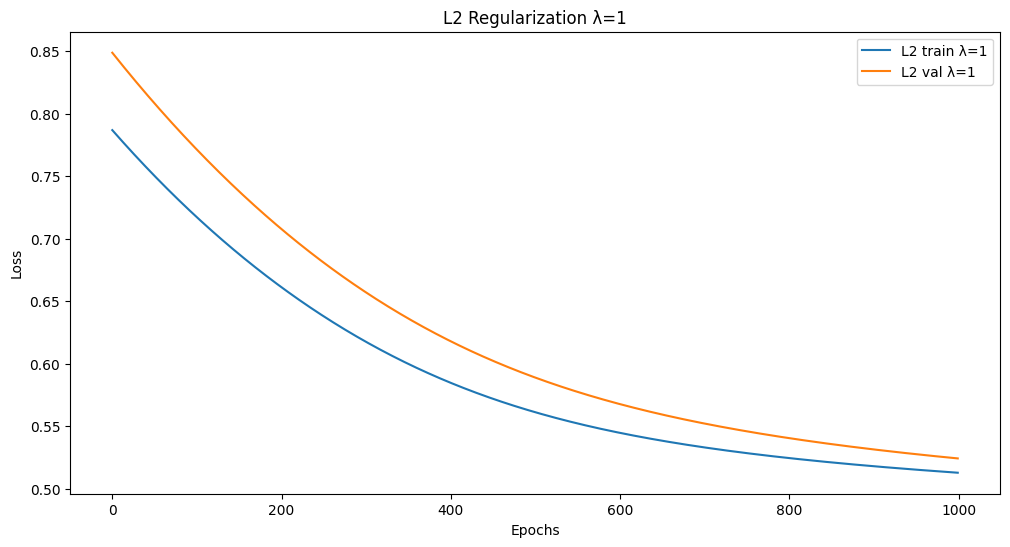

L2 Reg Validation BCE with λ=1: 0.5240701541648812


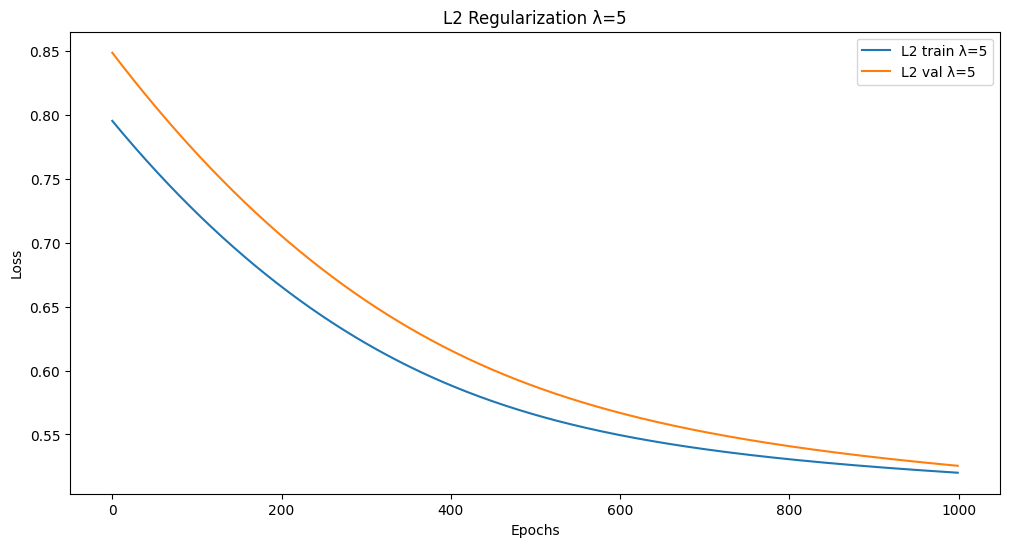

L2 Reg Validation BCE with λ=5: 0.5254408643097707


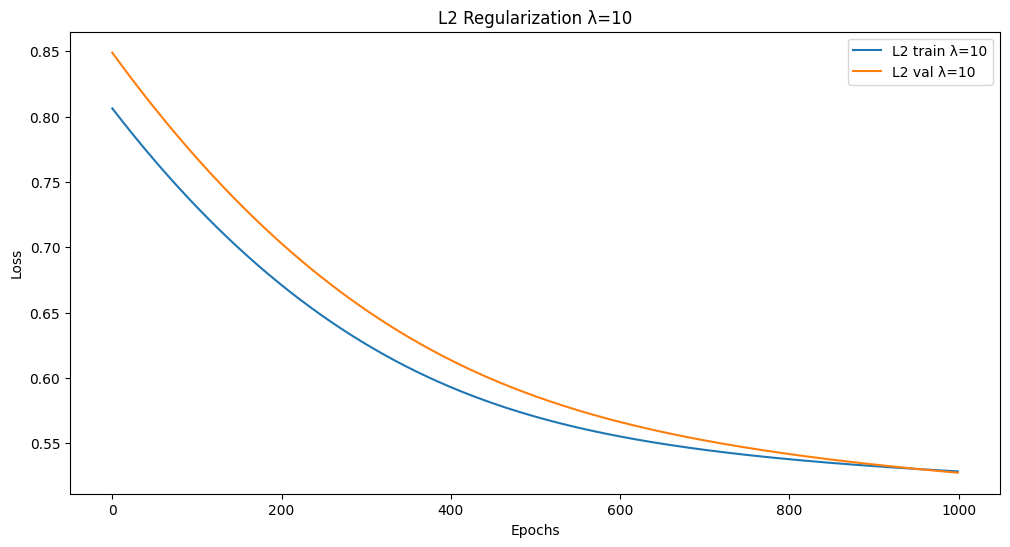

L2 Reg Validation BCE with λ=10: 0.5273351863610639
     PassengerId  Survived
0            892         0
1            893         0
2            894         0
3            895         0
4            896         1
..           ...       ...
413         1305         0
414         1306         1
415         1307         0
416         1308         0
417         1309         0

[418 rows x 2 columns]


In [35]:
# From-Scratch Logistic Regression
# enhanced features but no feature engineering
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def stratified_split(X, y, test_size, seed):
    if seed is not None:
        np.random.seed(seed)

    unique_classes = np.unique(y) # [0, 1]
    train_indices = []
    test_indices = []

    for cls in unique_classes:
        cls_indices = np.where(y == cls)[0] # where y = 0, y = 1
        np.random.shuffle(cls_indices)
        
        idx = int(len(cls_indices) * test_size)
        train_indices.extend(cls_indices[idx:])
        test_indices.extend(cls_indices[:idx])

    train_indices = np.array(train_indices)
    test_indices = np.array(test_indices)

    X_train = X.iloc[train_indices].reset_index(drop=True)
    y_train = y.iloc[train_indices].reset_index(drop=True)
    X_test = X.iloc[test_indices].reset_index(drop=True)
    y_test = y.iloc[test_indices].reset_index(drop=True)
    
    return X_train, y_train, X_test, y_test

def PandasOneHotEncodeNumpy(DataFrame, Columns):
    # receives a dataframe and a list columns
    # and one-hot-encodes the data
    # returns K-1 columns for K categories
    df = DataFrame.copy()

    new_cols = []
    # loop through the columns
    for column in Columns:
        unique = df[column].unique(); # get all the unique values
        unique.sort();
        index = df.columns.get_loc(column)
        
        # loop through the unique values, excluding the end
        for i in range(len(unique)-1):
            name = column + "_" + str(unique[i])
            df.insert(index, name, 0)
            df.loc[df[column] == unique[i], name] = 1
            
            index += 1
            new_cols.append(name)
            
        df = df.drop(column, axis=1) # drop the column

    return df.to_numpy(dtype='float32'), new_cols
            
def z_score_normalization(DataFrame, Columns):
    df = DataFrame.copy()
    
    for column in Columns:
        mean = df[column].mean()
        std = df[column].std()

        name = 'Z_' + column
        index = df.columns.get_loc(column)
        df.insert(index, name, 0)
        df[name] = (df[column] - mean) / std
        df = df.drop(column, axis=1)

    return df

def sigmoid(z):
    return 1/(1+np.exp(-z))

def initialize_params(m_features, seed=None):
    if seed is not None:
        np.random.seed(seed)
    
    w = np.random.rand(m_features, 1)
    b = 0
    return w, b


def forward(X, w, b):
    # X = m x n
    # w = n x 1
    
    z = np.dot(X, w) + b
    y_hat = sigmoid(z)
    return z, y_hat

def compute_cost(y, y_hat, W=None, reg=None, regLambda=0.0):
    y_hat = y_hat.reshape(-1, 1)
    y = y.reshape(-1, 1)

    # get epsilon
    eps = np.finfo(float).eps

    # compute cost as if there is no regularization
    n = len(y)
    cost = -1/n * np.sum(y * np.log(y_hat + eps) + (1-y) * np.log(1-y_hat + eps))

    if reg == 'L1' and W is not None:
        cost += (regLambda / n) * np.sum(np.abs(W))   
    elif reg == 'L2' and W is not None:
        cost += (regLambda / (2 * n)) * np.sum(W ** 2)
        
    return cost
    
def compute_gradients(X, y, y_hat, W=None, reg=None, regLambda=0.0):
    y_hat = y_hat.reshape(-1, 1)
    y = y.reshape(-1, 1)

    # compute dw and db
    n = len(y)
    dw = 1/n * np.dot(X.T, y_hat-y)
    db = 1/n * np.sum(y_hat -  y)

    if reg == 'L1' and W is not None:
        # sign() just gives 1 or -1 based on if the weight was pos or neg
        # each weight will just derive down to either 1 or -1
        dw += (regLambda / n) * np.sign(W)
    elif reg == 'L2' and W is not None:
        dw += (regLambda / n) * W
        
    return dw, db

def update_params(w, b, dw, db, lr):
    w = w - (lr*dw)
    b = b - (lr*db)
    return w, b

def train(X, y, lr, n_epochs, X_val=None, y_val=None, reg=None, regLambda=0.0):
    w, b = initialize_params(np.shape(X)[1], 425)

    train_costs = []
    val_costs = []
    for x in range(0, n_epochs):
        z, y_hat = forward(X, w, b)
        
        # compute training cost
        train_cost = compute_cost(y, y_hat, w, reg, regLambda)
        train_costs.append(train_cost)

        if X_val is not None and y_val is not None:
            z_val, y_hat_val = forward(X_val, w, b)
            val_cost = compute_cost(y_val, y_hat_val)
            val_costs.append(val_cost)
        
        dw, db = compute_gradients(X, y, y_hat, w, reg, regLambda)
        w, b = update_params(w, b, dw, db, lr)

    if X_val is not None and y_val is not None:
        return w, b, train_costs, val_costs
    
    return w, b, train_costs

def predict_proba(X, w, b):
    z = np.dot(X, w) + b
    y_hat = sigmoid(z)
    return y_hat

# very simple prediction function
def predict(y_hat):
    y_hat[y_hat >= 0.5] = 1
    y_hat[y_hat < 0.5] = 0
    return y_hat

train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")

# data preparation
y = train_data['Survived']
X = train_data.drop(columns=['PassengerId', 'Survived', 'Name', 'Ticket', 'Cabin'])

# stratified split first, then preprocess the data
X_train, y_train, X_val, y_val = stratified_split(X, y, 0.2, 18)

# handle training set first
X_train['Age'] = X_train['Age'].fillna(X_train['Age'].median())
X_train['Fare'] = X_train['Fare'].fillna(X_train['Fare'].median())
X_train['Embarked'] = X_train['Embarked'].fillna(X_train['Embarked'].mode()[0])
X_train = z_score_normalization(X_train, ["Age", "Fare", "SibSp", "Parch"])
X_train, new_cols = PandasOneHotEncodeNumpy(X_train, ["Pclass", "Sex", "Embarked"])

# then validation set
X_val['Age'] = X_val['Age'].fillna(X_val['Age'].median())
X_val['Fare'] = X_val['Fare'].fillna(X_val['Fare'].median())
X_val['Embarked'] = X_val['Embarked'].fillna(X_val['Embarked'].mode()[0])
X_val = z_score_normalization(X_val, ["Age", "Fare", "SibSp", "Parch"])
X_val, new_cols = PandasOneHotEncodeNumpy(X_val, ["Pclass", "Sex", "Embarked"])

# finally, do the test set
test_ids = test_data['PassengerId']
test_data = test_data.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'])
test_data['Age'] = test_data['Age'].fillna(test_data['Age'].median())
test_data['Fare'] = test_data['Fare'].fillna(test_data['Fare'].median())
test_data['Embarked'] = test_data['Embarked'].fillna(test_data['Embarked'].mode()[0])
test_data = z_score_normalization(test_data, ["Age", "Fare", "SibSp", "Parch"])
test_data, new_cols = PandasOneHotEncodeNumpy(test_data, ["Pclass", "Sex", "Embarked"])

print(new_cols)

# convert dataframes to np arrays
y_val = y_val.to_numpy()
y_train = y_train.to_numpy()

# train w/o regularization
w, b, train_costs, val_costs = train(X_train, y_train, 0.01, 1000, X_val, y_val)

plt.figure(figsize=(12,6))
plt.plot(train_costs, label=f'No Reg train')
plt.plot(val_costs, label=f'No Reg val')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('No Regularization')
plt.legend()
plt.show()

y_val_proba = predict_proba(X_val, w, b)
bce_none = compute_cost(y_val, y_val_proba)
print("No Reg Validation BCE:", bce_none)

l1 = [1, 5, 10]

for lam in l1:
    w, b, train_costs, val_costs = train(X_train, y_train, 0.01, 1000, X_val, y_val, 'L1', lam)
    plt.figure(figsize=(12,6))
    plt.plot(train_costs, label=f'L1 train λ={lam}')
    plt.plot(val_costs, label=f'L1 val λ={lam}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'L1 Regularization λ={lam}')
    plt.legend()
    plt.show()
    y_val_proba = predict_proba(X_val, w, b)
    bce = compute_cost(y_val, y_val_proba)
    print(f"L1 Reg Validation BCE with λ={lam}: {bce}")

l2 = [1, 5, 10]

for lam in l2:
    w, b, train_costs, val_costs = train(X_train, y_train, 0.01, 1000, X_val, y_val, 'L2', lam)
    plt.figure(figsize=(12,6))
    plt.plot(train_costs, label=f'L2 train λ={lam}')
    plt.plot(val_costs, label=f'L2 val λ={lam}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'L2 Regularization λ={lam}')
    plt.legend()
    plt.show()

    y_val_proba = predict_proba(X_val, w, b)
    bce = compute_cost(y_val, y_val_proba)
    print(f"L2 Reg Validation BCE with λ={lam}: {bce}")

# best-performing
w, b, train_costs, val_costs = train(X_train, y_train, 0.01, 1000, X_val, y_val, 'L2', 10)

predictions = predict(predict_proba(test_data, w, b)).flatten()
predictions = predictions.astype(int)
submission = pd.DataFrame({'PassengerId': test_ids, 'Survived': predictions})
filename = 'Titanic-Submission-FS.csv'
submission.to_csv(filename, index=False)
print(submission)



['Pclass_1', 'Pclass_2', 'Sex_female', 'Embarked_C', 'Embarked_Q']
     PassengerId  Survived
0            892         0
1            893         0
2            894         0
3            895         0
4            896         1
..           ...       ...
413         1305         0
414         1306         1
415         1307         0
416         1308         0
417         1309         0

[418 rows x 2 columns]


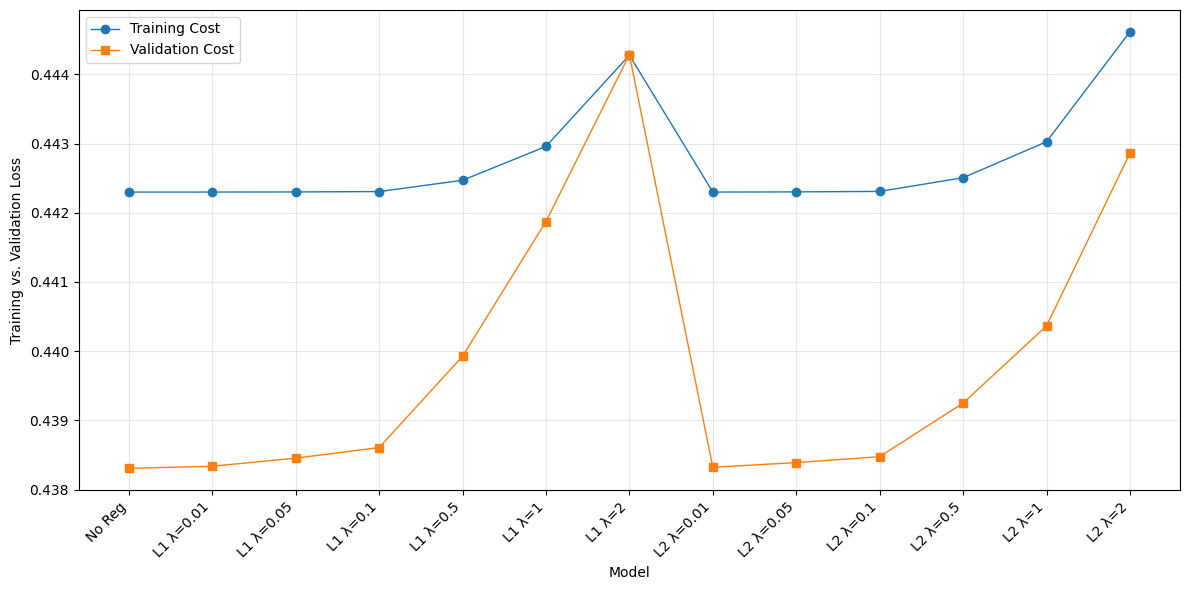

In [33]:
# SKLearn implementation but no feature engineering

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def stratified_split(X, y, test_size, seed):
    if seed is not None:
        np.random.seed(seed)

    unique_classes = np.unique(y) # [0, 1]
    train_indices = []
    test_indices = []

    for cls in unique_classes:
        cls_indices = np.where(y == cls)[0] # where y = 0, y = 1
        np.random.shuffle(cls_indices)
        
        idx = int(len(cls_indices) * test_size)
        train_indices.extend(cls_indices[idx:])
        test_indices.extend(cls_indices[:idx])

    train_indices = np.array(train_indices)
    test_indices = np.array(test_indices)

    X_train = X.iloc[train_indices].reset_index(drop=True)
    y_train = y.iloc[train_indices].reset_index(drop=True)
    X_test = X.iloc[test_indices].reset_index(drop=True)
    y_test = y.iloc[test_indices].reset_index(drop=True)
    
    return X_train, y_train, X_test, y_test

def PandasOneHotEncodeNumpy(DataFrame, Columns):
    # receives a dataframe and a list columns
    # and one-hot-encodes the data
    # returns K-1 columns for K categories
    df = DataFrame.copy()

    new_cols = []
    # loop through the columns
    for column in Columns:
        unique = df[column].unique(); # get all the unique values
        unique.sort();
        index = df.columns.get_loc(column)
        
        # loop through the unique values, excluding the end
        for i in range(len(unique)-1):
            name = column + "_" + str(unique[i])
            df.insert(index, name, 0)
            df.loc[df[column] == unique[i], name] = 1
            
            index += 1
            new_cols.append(name)
            
        df = df.drop(column, axis=1) # drop the column

    return df.to_numpy(dtype='float32'), new_cols
            
def z_score_normalization(DataFrame, Columns):
    df = DataFrame.copy()
    
    for column in Columns:
        mean = df[column].mean()
        std = df[column].std()

        name = 'Z_' + column
        index = df.columns.get_loc(column)
        df.insert(index, name, 0)
        df[name] = (df[column] - mean) / std
        df = df.drop(column, axis=1)

    return df

train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")

# data preparation
y = train_data['Survived']
X = train_data.drop(columns=['PassengerId', 'Survived', 'Name', 'Ticket', 'Cabin'])

# stratified split first, then preprocess the data
X_train, y_train, X_val, y_val = stratified_split(X, y, 0.2, 18)

# handle training set first
X_train['Age'] = X_train['Age'].fillna(X_train['Age'].median())
X_train['Fare'] = X_train['Fare'].fillna(X_train['Fare'].median())
X_train['Embarked'] = X_train['Embarked'].fillna(X_train['Embarked'].mode()[0])
X_train = z_score_normalization(X_train, ["Age", "Fare", "SibSp", "Parch"])
X_train, new_cols = PandasOneHotEncodeNumpy(X_train, ["Pclass", "Sex", "Embarked"])

# then validation set
X_val['Age'] = X_val['Age'].fillna(X_val['Age'].median())
X_val['Fare'] = X_val['Fare'].fillna(X_val['Fare'].median())
X_val['Embarked'] = X_val['Embarked'].fillna(X_val['Embarked'].mode()[0])
X_val = z_score_normalization(X_val, ["Age", "Fare", "SibSp", "Parch"])
X_val, new_cols = PandasOneHotEncodeNumpy(X_val, ["Pclass", "Sex", "Embarked"])

# finally, do the test set
test_ids = test_data['PassengerId']
test_data = test_data.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'])
test_data['Age'] = test_data['Age'].fillna(test_data['Age'].median())
test_data['Fare'] = test_data['Fare'].fillna(test_data['Fare'].median())
test_data['Embarked'] = test_data['Embarked'].fillna(test_data['Embarked'].mode()[0])
test_data = z_score_normalization(test_data, ["Age", "Fare", "SibSp", "Parch"])
test_data, new_cols = PandasOneHotEncodeNumpy(test_data, ["Pclass", "Sex", "Embarked"])

print(new_cols)

# convert dataframes to np arrays
y_val = y_val.to_numpy()
y_train = y_train.to_numpy()

models = []
train_cost = []
val_cost = []

# no regularization
model = LogisticRegression(penalty=None, solver='lbfgs', max_iter=1000)
model.fit(X_train, y_train)
models.append('No Reg')
train_cost.append(log_loss(y_train, model.predict_proba(X_train)[:, 1]))
val_cost.append(log_loss(y_val, model.predict_proba(X_val)[:, 1]))

predictions = model.predict(test_data)
submission = pd.DataFrame({'PassengerId': test_ids, 'Survived': predictions})
filename = 'Titanic-Submission-SK.csv'
submission.to_csv(filename, index=False)

print(submission)

lambdas = [0.01, 0.05, 0.1, 0.5, 1, 2]
# L1

for lam in lambdas:
    model = LogisticRegression(penalty='l1', C=1/lam, solver='liblinear', max_iter=1000)
    model.fit(X_train, y_train)
    y_val_proba = model.predict_proba(X_val)[:, 1]
    models.append(f"L1 λ={lam}")
    train_cost.append(log_loss(y_train, model.predict_proba(X_train)[:, 1]))
    val_cost.append(log_loss(y_val, model.predict_proba(X_val)[:, 1]))
    
# L2
for lam in lambdas:
    model = LogisticRegression(penalty='l2', C=1/lam, solver='lbfgs', max_iter=1000)
    model.fit(X_train, y_train)
    models.append(f"L2 λ={lam}")
    train_cost.append(log_loss(y_train, model.predict_proba(X_train)[:, 1]))
    val_cost.append(log_loss(y_val, model.predict_proba(X_val)[:, 1]))

plt.figure(figsize=(12,6))
plt.plot(models, train_cost, 'o-', label='Training Cost', linewidth=1)
plt.plot(models, val_cost, 's-', label='Validation Cost', linewidth=1)
plt.xlabel('Model')
plt.ylabel('Training vs. Validation Loss')
plt.xticks(rotation=45, ha='right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.legend()
plt.show()

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import accuracy_score

train = pd.read_csv("/kaggle/input/titanic/train.csv")
test = pd.read_csv("/kaggle/input/titanic/test.csv")

test_ids = test['PassengerId']

y = train['Survived']
X = train.drop(columns=['PassengerId', 'Survived', 'Name', 'Ticket', 'Cabin'])

X_test = test.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'])

numeric_feats = ['Age', 'Fare', 'SibSp', 'Parch']
categorical_feats = ['Pclass', 'Sex', 'Embarked']

numeric_transformer = Pipeline(
    steps=[('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())]
)

categorical_transformer = Pipeline(
    steps=[
        ('encoder', OneHotEncoder(handle_unknown='ignore')),
        ('selector', SelectPercentile(chi2, percentile=50)),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_feats),
        ('cat', categorical_transformer, categorical_feats),
    ]
)

params = {
    'clf__bootstrap': [True, False],
    'clf__min_samples_split': [2, 4, 8],
    'clf__min_samples_leaf': [1, 2, 4],
    'clf__max_depth': [None, 4, 8, 16, 32]
}

clf = Pipeline(
    steps=[('preprocessor', preprocessor), ('classifier', LogisticRegression())]
)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

rf = Pipeline([
    ('preproc', preprocessor),
    ('clf', RandomForestClassifier(random_state=42, n_jobs=-1))
])

rsearch = RandomizedSearchCV(
    estimator=rf,
    param_distributions=params,
    n_iter=32,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42,    
)

rsearch.fit(X_train, y_train)
best_rf = rsearch.best_estimator_
print("Best hyperparameters:", rsearch.best_params_)

y_train_proba = best_rf.predict(X_train)
y_val_proba = best_rf.predict(X_val)

train_acc = accuracy_score(y_train, y_train_proba)
val_acc = accuracy_score(y_val, y_val_proba)
print(f"Random Forest -> train acc: {train_acc:.4f}, val acc: {val_acc:.4f}")



Best hyperparameters: {'clf__min_samples_split': 4, 'clf__min_samples_leaf': 2, 'clf__max_depth': 32, 'clf__bootstrap': True}
Random Forest -> train acc: 0.9101, val acc: 0.8156
